In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

 # Faster R-CNN + ResNet

In [24]:
!pip install torch torchvision pycocotools tqdm pillow --quiet

import os
import torch
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import CocoDetection
import numpy as np
from PIL import Image, ImageDraw
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchvision.transforms import functional as F

# Caminhos e Classes (Adaptado para /kaggle/input/)

In [25]:
# SUBSTITUA 'robocup-coco-dataset' pelo nome do seu dataset no Kaggle
base_dir = "/kaggle/input/robocup-2-0" 

# Caminhos de Treinamento
# A estrutura de pastas 'robocup_coco' deve ser a raiz do seu upload.
train_dir = os.path.join(base_dir, "robocup_coco", "train", "Imagens")
train_ann = os.path.join(base_dir, "robocup_coco", "train", "_annotations.coco.json")

# Caminhos de Validação
val_dir = os.path.join(base_dir, "robocup_coco", "valid", "Imagens")
val_ann = os.path.join(base_dir, "robocup_coco", "valid", "_annotations.coco.json")

# Diretório de output no Kaggle (para salvar checkpoints)
output_dir = "/kaggle/outputs/robocup_output"
os.makedirs(output_dir, exist_ok=True)

# =======================
# DEFINIÇÃO DAS CLASSES
# =======================
CLASSES = [
    "AllenKey", "Axis2", "Bearing2", "Drill", "F20_20_B", "F20_20_G",
    "Housing", "M20", "M20_100", "M30", "Motor2", "S40_40_B", "S40_40_G",
    "Screwdriver", "Spacer", "Wrench", "container_box_blue", "container_box_red"
]
NUM_CLASSES = len(CLASSES) + 1  # +1 para background

# TRANSFORMAÇÕES

In [26]:
class Compose(object):
    """Compõe múltiplas transformações."""
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target_list):
        # target_list é a lista de dicts COCO
        for t in self.transforms:
            image, target_list = t(image, target_list)
        return image, target_list


class ToTensor(object):
    """Converte a imagem (PIL Image) para Tensor e mantém o target_list inalterado."""
    def __call__(self, image, target_list):
        if isinstance(image, Image.Image):
            image = F.to_tensor(image)
        # Retorna a lista de targets COCO inalterada
        return image, target_list


class RandomHorizontalFlip(object):
    """Inverte a imagem e ajusta as caixas delimitadoras COCO ([x, y, w, h])."""
    def __init__(self, flip_prob):
        self.flip_prob = flip_prob

    def __call__(self, image, target_list):
        if np.random.rand() < self.flip_prob:
            # 1. Flip a imagem
            image = F.hflip(image)

            # 2. Obtém a largura da imagem
            if isinstance(image, torch.Tensor):
                # Se ToTensor foi aplicado antes
                width = image.shape[-1]
            else:  # Caso seja PIL Image
                width = image.width

            # 3. Ajusta as caixas delimitadoras (formato COCO: [x_min, y_min, w, h])
            # A inversão horizontal afeta apenas o x_min.
            # Novo x_min = width - (x_min_antigo + w)
            for obj in target_list:
                bbox = obj["bbox"]  # [x_min, y_min, w, h]
                x_min_old = bbox[0]
                w = bbox[2]

                # Calcula o novo x_min
                new_x_min = width - (x_min_old + w)

                # Atualiza o x_min na anotação COCO
                bbox[0] = new_x_min

        return image, target_list


def get_transform(train):
    """Define a composição de transformações para treinamento ou validação."""
    transforms_list = [ToTensor()]
    if train:
        # A RandomHorizontalFlip DEVE ser aplicada antes da conversão final para [x_min, y_min, x_max, y_max]
        transforms_list.append(RandomHorizontalFlip(0.5))
    return Compose(transforms_list)


# =======================
# DATASET COCO
# =======================

class CocoDataset(CocoDetection):
    """
    Dataset wrapper que aplica transformações e converte targets COCO
    (lista de dicts [x, y, w, h]) para o formato de Tensor do modelo
    (dict com 'boxes' [x_min, y_min, x_max, y_max]).
    """
    def __init__(self, img_folder, ann_file, transforms=None):
        # NÃO passe 'transforms' para o super().__init__ para controlar o fluxo
        super().__init__(img_folder, ann_file)
        self.transforms = transforms
        # Usamos self.ids para obter o COCO image_id real
        self.ids = list(self.coco.imgs.keys())

    def __getitem__(self, idx):
        # 1. Obter o ID real da imagem COCO
        # Usamos o 'idx' (índice da iteração) para buscar o 'image_id' real no mapeamento do dataset.
        img_id = self.ids[idx]

        # 2. Busca a imagem e anotações. A CocoDetection base deve ser chamada com o ÍNDICE DE ITERAÇÃO.
        # A correção é usar 'idx' aqui, em vez de 'img_id'.
        # A base CocoDetection usa 'idx' para buscar o ID da imagem e as anotações.
        img, target_list = super().__getitem__(idx) # ✅ CORREÇÃO: Passar 'idx' (índice), não 'img_id'


        # 3. Aplica as transformações (que modificam a imagem PIL/Tensor e a target_list COCO)
        if self.transforms:
            img, target_list = self.transforms(img, target_list)

        # 4. Converte a target_list (JÁ TRANSFORMADA) para o formato de Tensores do Modelo
        boxes, labels = [], []
        for obj in target_list:
            x_min, y_min, w, h = obj["bbox"]
            # Converte de [x, y, w, h] (COCO) para [x_min, y_min, x_max, y_max] (PyTorch)
            boxes.append([x_min, y_min, x_min + w, y_min + h])
            labels.append(obj["category_id"])

        # Lidar com o caso de imagens sem caixas delimitadoras
        if not boxes:
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.zeros((0,), dtype=torch.int64)
        else:
            boxes = torch.as_tensor(boxes, dtype=torch.float32)
            labels = torch.as_tensor(labels, dtype=torch.int64)

        # Cria o dicionário final para o modelo
        target = {
            "boxes": boxes,
            "labels": labels,
            # Mantemos o image_id real (buscado no passo 1) no target
            "image_id": torch.tensor([img_id])
        }

        # Opcional: Adicionar área e is_crowd, se necessário pelo modelo
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        is_crowd = torch.zeros((len(labels),), dtype=torch.uint8)
        target["area"] = area
        target["iscrowd"] = is_crowd

        return img, target


def collate_fn(batch):
    """
    Função de colagem customizada para lidar com targets de tamanhos variáveis.
    Requerida por DataLoaders em tarefas de Detecção de Objetos.
    """
    # Descompacta o batch: (img1, target1), (img2, target2), ...
    return tuple(zip(*batch))

# DATALOADERS, MODELO E SETUP (Otimizado)

In [27]:
# =======================
# DATALOADERS (Otimizados)
# =======================
train_dataset = CocoDataset(train_dir, train_ann, transforms=get_transform(True))
val_dataset = CocoDataset(val_dir, val_ann, transforms=get_transform(False))

# Otimização de Velocidade: Aumente batch_size e ajuste num_workers
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True,  
                          num_workers=4, collate_fn=collate_fn)      
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False,
                        num_workers=2, collate_fn=collate_fn)      


# =======================
# MODELO
# =======================
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, NUM_CLASSES)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# =======================
# OTIMIZADOR E SCHEDULER
# =======================
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.1)

loading annotations into memory...
Done (t=0.94s)
creating index...
index created!
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


# LOOP DE TREINAMENTO

In [28]:
NUM_EPOCHS = 1

output_dir = "/kaggle/working/robocup_output"
os.makedirs(output_dir, exist_ok=True)

for epoch in range(NUM_EPOCHS):
    model.train()
    epoch_loss = 0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}")
    for imgs, targets in pbar:
        imgs = [img.to(device) for img in imgs]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(imgs, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        epoch_loss += losses.item()
        pbar.set_postfix({"loss": losses.item()})

    lr_scheduler.step()
    print(f"Epoch [{epoch+1}] Loss: {epoch_loss/len(train_loader):.4f}")

    # Salvar checkpoint
    ckpt_path = os.path.join(output_dir, f"model_epoch_{epoch+1}.pth")
    torch.save(model.state_dict(), ckpt_path)

    # Avaliação rápida
    model.eval()
    imgs, _ = next(iter(val_loader))
    imgs = [img.to(device) for img in imgs]
    with torch.no_grad():
        preds = model(imgs)
    pred = preds[0]
    img = imgs[0].cpu().permute(1, 2, 0).numpy()
    img = (img * 255).astype(np.uint8)
    img_pil = Image.fromarray(img)
    draw = ImageDraw.Draw(img_pil)

    for box, label, score in zip(pred['boxes'], pred['labels'], pred['scores']):
        if score >= 0.5:
            x1, y1, x2, y2 = box
            draw.rectangle([x1, y1, x2, y2], outline="red", width=2)
            class_name = CLASSES[label-1] if label > 0 and label <= len(CLASSES) else "?"
            draw.text((x1, y1), f"{class_name} {score:.2f}", fill="red")

    out_path = os.path.join(output_dir, f"val_pred_epoch_{epoch+1}.jpg")
    img_pil.save(out_path)
    print(f"Imagem de validação salva em: {out_path}")

print("Treinamento concluído ✅")

Epoch 1/1:   7%|▋         | 586/8613 [08:29<1:56:16,  1.15it/s, loss=0.243]


KeyboardInterrupt: 

Usando dispositivo: cuda


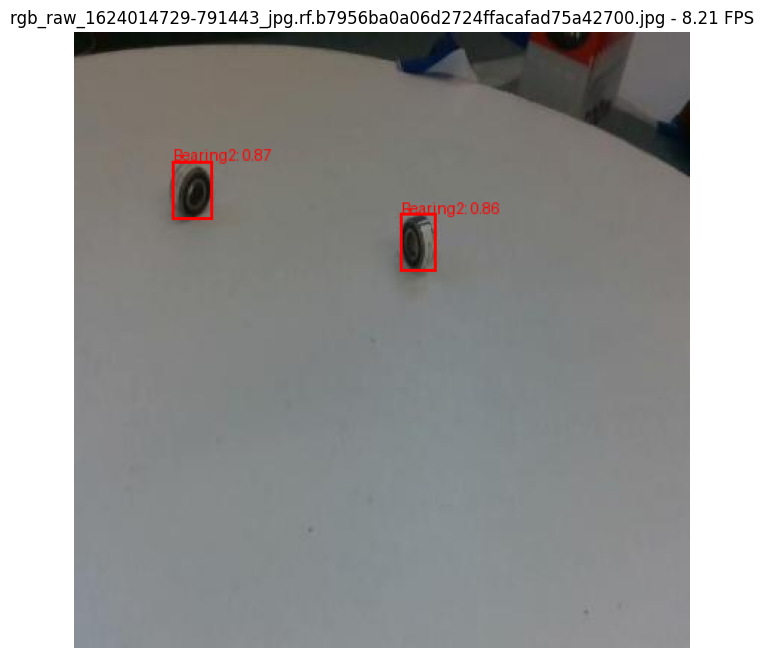

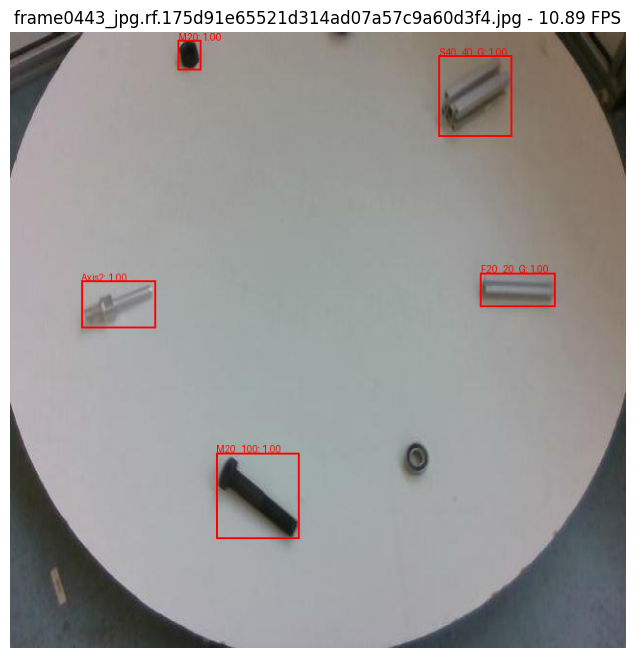

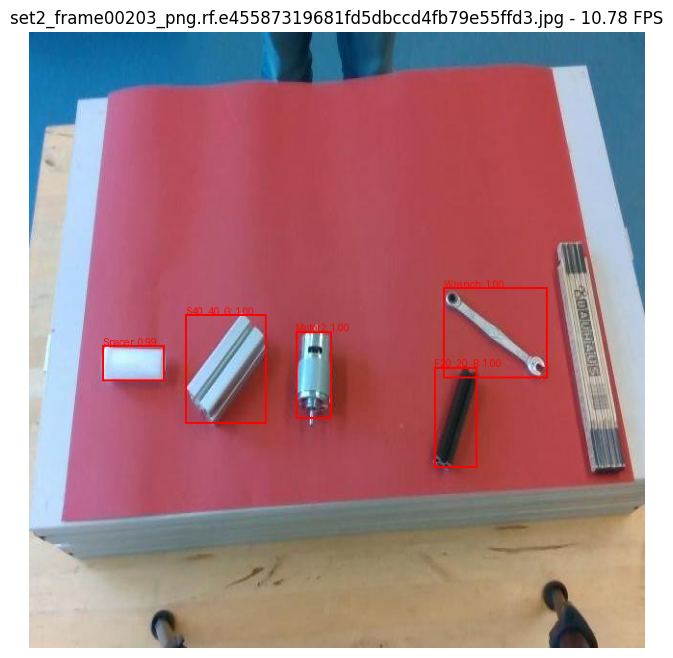

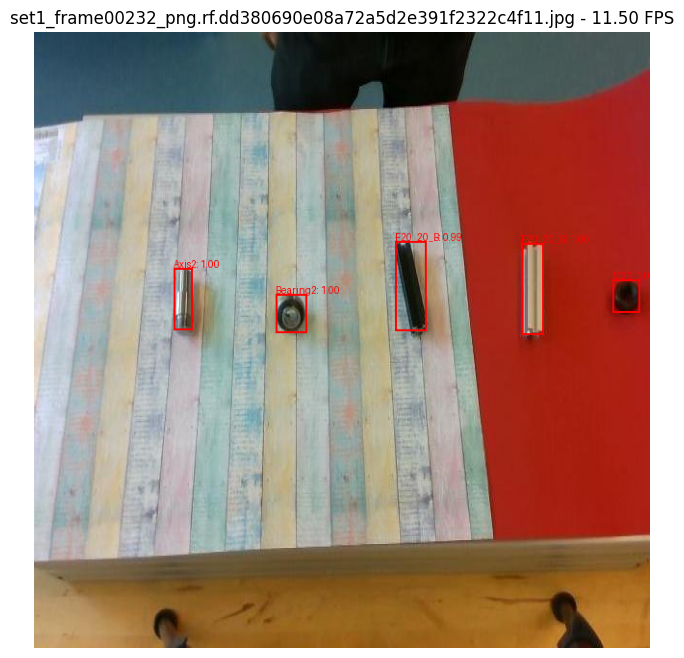

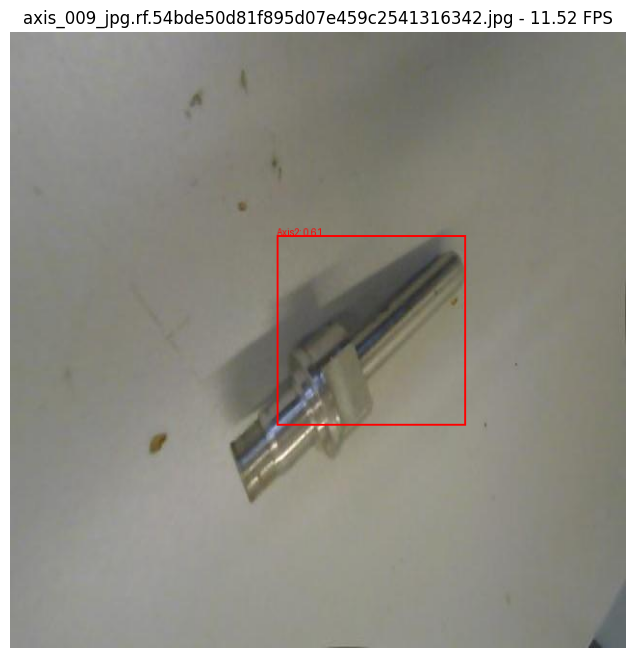


✅ Inferência concluída para 5 imagens.
📈 FPS médio: 10.58


In [33]:
import torch, torchvision, time, random, os
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from torchvision.transforms import functional as F
import numpy as np

# ==============================
# CONFIGURAÇÕES
# ==============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

# Classes do seu dataset Robocup
CLASSES = [
    "__background__",  # 🔹 fundo
    "AllenKey", "Axis2", "Bearing2", "Drill", "F20_20_B", "F20_20_G",
    "Housing", "M20", "M20_100", "M30", "Motor2", "S40_40_B", "S40_40_G",
    "Screwdriver", "Spacer", "Wrench", "container_box_blue", "container_box_red"
]

# Número de classes incluindo background
NUM_CLASSES = len(CLASSES)

# Caminho para o modelo .pth que você vai subir
model_path = "/kaggle/input/checkpoint-robocup-coco/model_epoch_11.pth"  

# Carrega o modelo treinado
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=None, num_classes=NUM_CLASSES)
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()

# Caminho das imagens de validação
val_dir = "/kaggle/input/robocup-2-0/robocup_coco/valid/Imagens"  

# Lista de imagens disponíveis
all_images = [f for f in os.listdir(val_dir) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
num_images = min(10, len(all_images))
random_images = random.sample(all_images, num_images)

# Lista para calcular FPS médio
fps_list = []

# ==============================
# LOOP DE INFERÊNCIA
# ==============================
for img_name in random_images:
    img_path = os.path.join(val_dir, img_name)
    img = Image.open(img_path).convert("RGB")
    img_tensor = F.to_tensor(img).unsqueeze(0).to(device)

    # Inferência + tempo
    start_time = time.time()
    with torch.no_grad():
        preds = model(img_tensor)
    elapsed = time.time() - start_time
    fps = 1 / elapsed
    fps_list.append(fps)

    # Resultados
    pred = preds[0]
    draw = ImageDraw.Draw(img)

    for box, label, score in zip(pred["boxes"], pred["labels"], pred["scores"]):
        if score >= 0.6:  # limiar de confiança
            x1, y1, x2, y2 = box
            class_name = CLASSES[label] if label < len(CLASSES) else f"id_{label}"
            draw.rectangle([x1, y1, x2, y2], outline="red", width=2)
            draw.text((x1, y1 - 10), f"{class_name}: {score:.2f}", fill="red")

    # Exibe resultado
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"{img_name} - {fps:.2f} FPS")
    plt.show()

# ==============================
# FPS MÉDIO
# ==============================
avg_fps = np.mean(fps_list)
print(f"\n✅ Inferência concluída para {num_images} imagens.")
print(f"📈 FPS médio: {avg_fps:.2f}")


In [39]:
import torch
import torchvision
from torchvision.datasets import CocoDetection
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torchvision.ops import box_iou
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import json
import os

# ==============================
# CONFIGURAÇÃO
# ==============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

# Classes do dataset (com background)
CLASSES = [
    "__background__",
    "AllenKey", "Axis2", "Bearing2", "Drill", "F20_20_B", "F20_20_G",
    "Housing", "M20", "M20_100", "M30", "Motor2", "S40_40_B", "S40_40_G",
    "Screwdriver", "Spacer", "Wrench", "container_box_blue", "container_box_red"
]
NUM_CLASSES = len(CLASSES)

# Caminho para o modelo treinado (.pth)
model_path = "/kaggle/input/checkpoint-robocup-coco/model_epoch_11.pth"

# ==============================
# CARREGAR MODELO
# ==============================
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=None, num_classes=NUM_CLASSES)
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()

# ==============================
# DATASET DE VALIDAÇÃO
# ==============================
val_dir = "/kaggle/input/robocup-2-0/robocup_coco/valid/Imagens"
val_ann = "/kaggle/input/robocup-2-0/robocup_coco/valid/_annotations.coco.json"

# Transformação para tensores
transform = ToTensor()

val_dataset = CocoDetection(
    root=val_dir,
    annFile=val_ann,
    transform=transform
)

val_loader = DataLoader(
    val_dataset,
    batch_size=2,
    shuffle=False,
    collate_fn=lambda x: tuple(zip(*x))
)

# ==============================
# CARREGAR LOSS SALVO DO TREINO
# ==============================
loss_file = "/kaggle/input/checkpoint-robocup-coco/train_losses.json"  # ajuste se necessário
if os.path.exists(loss_file):
    with open(loss_file, "r") as f:
        train_losses = json.load(f)
else:
    print("Arquivo de perdas do treino não encontrado, criando lista vazia.")
    train_losses = []

# ==============================
# FUNÇÃO PARA CALCULAR mAP
# ==============================
def calculate_map(model, data_loader, device, iou_threshold=0.5, score_threshold=0.5):
    model.eval()
    aps = []

    with torch.no_grad():
        for imgs, targets in tqdm(data_loader, desc="Calculando mAP"):
            imgs = [img.to(device) for img in imgs]
            outputs = model(imgs)

            for output, t in zip(outputs, targets):
                # t é uma lista de anotação COCO, cada elemento é um dict com 'bbox', 'category_id', etc
                gt_boxes = []
                for ann in t:  # itera diretamente sobre o target
                    bbox = ann['bbox']  # [x, y, w, h]
                    bbox[2] += bbox[0]  # x2 = x + w
                    bbox[3] += bbox[1]  # y2 = y + h
                    gt_boxes.append(bbox)

                gt_boxes = torch.tensor(gt_boxes, dtype=torch.float32).to(device)

                pred_boxes = output['boxes'][output['scores'] >= score_threshold]

                if len(pred_boxes) == 0 or len(gt_boxes) == 0:
                    aps.append(0)
                    continue

                ious = box_iou(pred_boxes, gt_boxes)
                matches = (ious >= iou_threshold).any(dim=1).float()
                ap = matches.mean().item()
                aps.append(ap)

    mAP = np.mean(aps) if aps else 0
    return mAP

# ==============================
# CALCULAR mAP DE VALIDAÇÃO
# ==============================
val_mAP = calculate_map(model, val_loader, device)
print(f"\n✅ mAP de validação: {val_mAP:.4f}")

# ==============================
# PLOTAR LOSS E mAP
# ==============================
plt.figure(figsize=(8,5))
# Se train_losses não existir, só plota mAP
plt.plot([1], [val_mAP], label='Validation mAP', marker='x', markersize=10)
plt.xlabel('Epoch')
plt.ylabel('mAP')
plt.title('Faster R-CNN - mAP de Validação')
plt.legend()
plt.grid(True)
plt.show()


Usando dispositivo: cuda
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
Arquivo de perdas do treino não encontrado, criando lista vazia.


Calculando mAP:  71%|███████   | 614/863 [02:01<00:49,  5.07it/s]


KeyboardInterrupt: 